# Introduction

This notebook seeks to implement a recommender, trained on 25% of the [movieLens dataset](https://grouplens.org/datasets/movielens/), to recommend movies to users. The notebook compares the traditional matrix factorization with a residual learning algorithm, to a new, deep learning collaborative filtering architecture described in a new research [*Deep Learning Architecture for Collaborative Filtering Recommender Systems*](https://www.researchgate.net/publication/340416554_Deep_Learning_Architecture_for_Collaborative_Filtering_Recommender_Systems) (DOI: 10.3390/app10072441) by J. Bobadilla, S.Alonso and A. Hernando, published in April 2020. 

Traditionally, the collaborative filtering (CF) approach can be implemented with residual deep learning as follows: 
for collaborative filtering/matrix factorization, $MF(x): r_{ij} = w_i \cdot u_j + b_i + c_j + \mu$. To explore the non-linear patterns, a feedforward neural network can be integrated to model the residual, that is $NN(x): \hat{r} - MF(x)$.

The deep learning architecture proposed by Bobadilla, Alonso, and Hernando is a Reliability-based Neural Collaborative Filtering (RNCF). In the first stage of the architecture, a traditional matrix factorization (MF) model is first trained on the users, items, and ratings. In the second stage, the mean squared errors (MSE) between the predictions from the MF model and the real ratings in the dataset are used as y-label targets to train a second model -- a multi-layer neural network (MNN) model. That is, this MNN is trained to take latent features of the users and items, then predict the MSEs that will be created by the MF model. In the third (last) stage, a third model, also an MNN, is trained to take latent features of users, items and the estimated error predicted by the second model, and output the predicted rating. Mathematically, 
* $MF(x): r_{ij} = w_i \cdot u_j$ (1)
* $MNN(x): (w_i, u_j) \to e_{ij} = (\hat{r} - MF(x))^2$ (2), and 
* $MNN_{2}(x): (w_i, u_j, e_{ij}) \to r$

<img src="Proposed-RNCF-architecture.png" alt="Proposed-RNCF-architecture.png" width="400"/>

The results have shown that the traditional CF/MF model with residual learning achieves a MSE of 0.65, comparing to the deep learning architecture's 1.11. Factors such as the reduced dataset size and the absense of bias and regularization, etc., may be attributed to this observation.

# Data Preprocessing

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import random
%matplotlib inline

In [2]:
movieDF = pd.read_csv("rating.csv")
movieDF.drop(['timestamp'], axis = 1, inplace = True)
movieDF.head(5)

,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5


Due to the constraint of time and computing power, only 25% of the entire movieLens dataset is used. The ratio used by train-test-split is 75%-25%. 

In [3]:
from sklearn.utils import shuffle

#Train Test split
ratio = int(0.25*len(movieDF))
movieDF = movieDF.iloc[:ratio]
movieDF = shuffle(movieDF)
trainSize = int(0.75*len(movieDF))
trainDF = movieDF.iloc[:trainSize]
testDF = movieDF.iloc[trainSize:]

# init
userNum = movieDF.userId.max() + 1
movieNum = movieDF.movieId.max() + 1
K = 15
MU = trainDF.rating.mean()
EPOCHS = 15
REGULAR = 0.1

# CF/MF with Residual Learning

### Model Definition

In [4]:
from keras.layers import Input, Embedding, Dense, Flatten, Concatenate, Add, Dot, Dropout, BatchNormalization, Activation
from keras.models import Model
from keras.optimizers import Adam, SGD

# input
userInput = Input(shape=(1,))
movieInput = Input(shape=(1,))

# Matrix Factorization
# Since userNum < movieNum, we have userNum = batchsize
userEmbedding = Embedding(userNum, K)(userInput) # bsize x 1 x k
movieEmbedding = Embedding(movieNum, K)(movieInput) # bsize x 1 x k
userBias = Embedding(userNum, 1)(userInput) # bsize x 1 x 1
movieBias = Embedding(movieNum, 1)(movieInput) # bsize x 1 x 1
model = Dot(axes=2)([userEmbedding, movieEmbedding]) # bsize x 1 x 1
model = Add()([model, userBias, movieBias])
model = Flatten()(model) # bsize x 1

# Residual
userEmbeddingFlat = Flatten()(userEmbedding) # bsize x k
movieEmbeddingFlat = Flatten()(movieEmbedding) # bsize x k
residual = Concatenate()([userEmbeddingFlat, movieEmbeddingFlat]) # bsize x 2k
residual = Dense(512)(residual)
residual = Activation('elu')(residual)
residual = Dense(1)(residual)

# Together
model = Add()([model, residual])
model = Model(inputs=[userInput, movieInput], outputs=model)
model.compile(
    loss='mse',
    optimizer=SGD(lr=0.08, momentum=0.9),
    metrics=['mse']
)

Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


### Training

In [5]:
history = model.fit(
    x=[trainDF.userId.values, trainDF.movieId.values],
    y=trainDF.rating.values - MU,
    epochs=EPOCHS,
    batch_size=128,
    validation_data=(
        [testDF.userId.values, testDF.movieId.values],
        testDF.rating.values - MU
    )
)


Train on 3750048 samples, validate on 1250017 samples
Epoch 1/15
3750048/3750048 [==============================] - 338s 90us/step - loss: 0.7744 - mse: 0.7744 - val_loss: 0.7291 - val_mse: 0.7291
Epoch 2/15
3750048/3750048 [==============================] - 337s 90us/step - loss: 0.7159 - mse: 0.7159 - val_loss: 0.7350 - val_mse: 0.7350
Epoch 3/15
3750048/3750048 [==============================] - 333s 89us/step - loss: 0.6971 - mse: 0.6971 - val_loss: 0.7072 - val_mse: 0.7072
Epoch 4/15
3750048/3750048 [==============================] - 342s 91us/step - loss: 0.6729 - mse: 0.6729 - val_loss: 0.6814 - val_mse: 0.6814
Epoch 5/15
3750048/3750048 [==============================] - 378s 101us/step - loss: 0.6406 - mse: 0.6406 - val_loss: 0.6640 - val_mse: 0.6640
Epoch 6/15
3750048/3750048 [==============================] - 453s 121us/step - loss: 0.6103 - mse: 0.6103 - val_loss: 0.6618 - val_mse: 0.6618
Epoch 7/15
3750048/3750048 [==============================] - 473s 126us/step - loss:

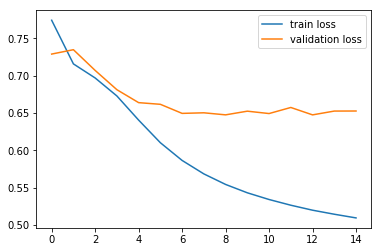

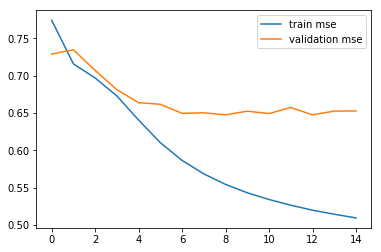

In [6]:
model.save("movieLensRecommender_res.h5")

def plot(history):
    plt.plot(history.history['loss'], label="train loss")
    plt.plot(history.history['val_loss'], label="validation loss")
    plt.legend()
    plt.show()
    
    plt.plot(history.history['mse'], label="train mse")
    plt.plot(history.history['val_mse'], label="validation mse")
    plt.legend()
    plt.show()
    
plot(history)

### Sample Inference

In [7]:
def predictRating0(num):
    result = model.predict([[movieDF.iloc[num].userId], [movieDF.iloc[num].movieId]])
    result = result[0][0] + MU
    print("(Predicted Rating, Real Rating): ({0}, {1})".format(result, movieDF.iloc[num].rating))

def test0(times):
    top = len(movieDF) - 1
    for _ in range(times):
        num = random.randint(0, top)
        predictRating0(num)

test0(20)

(Predicted Rating, Real Rating): (3.9147259311229496, 4.0)
(Predicted Rating, Real Rating): (3.783999176457575, 3.5)
(Predicted Rating, Real Rating): (4.751980812981776, 5.0)
(Predicted Rating, Real Rating): (3.6924745456725865, 3.5)
(Predicted Rating, Real Rating): (3.7110037223846226, 5.0)
(Predicted Rating, Real Rating): (4.616799505189112, 5.0)
(Predicted Rating, Real Rating): (2.565714390710047, 3.0)
(Predicted Rating, Real Rating): (2.430528910592249, 3.5)
(Predicted Rating, Real Rating): (4.06956151290243, 4.0)
(Predicted Rating, Real Rating): (3.70680299563711, 0.5)
(Predicted Rating, Real Rating): (3.142650456860712, 3.0)
(Predicted Rating, Real Rating): (4.06136956973379, 5.0)
(Predicted Rating, Real Rating): (3.691233725979975, 3.5)
(Predicted Rating, Real Rating): (4.683683784440211, 5.0)
(Predicted Rating, Real Rating): (4.001659901574305, 3.5)
(Predicted Rating, Real Rating): (2.058595807984522, 1.0)
(Predicted Rating, Real Rating): (3.2210759834796696, 4.0)
(Predicted Ra

# Deep Learning RNCF

## Model 1: MF

In [8]:
# input
userInput = Input(shape=(1,))
movieInput = Input(shape=(1,))

# Matrix Factorization
# Since userNum < movieNum, we have userNum = batchsize
userEmbedding = Embedding(userNum, K)(userInput) # bsize x 1 x k
movieEmbedding = Embedding(movieNum, K)(movieInput) # bsize x 1 x k
userBias = Embedding(userNum, 1)(userInput) # bsize x 1 x 1
movieBias = Embedding(movieNum, 1)(movieInput) # bsize x 1 x 1
model1 = Dot(axes=2)([userEmbedding, movieEmbedding]) # bsize x 1 x 1
model1 = Add()([model1, userBias, movieBias])
model1 = Flatten()(model1) # bsize x 1

# Together
model1 = Model(inputs=[userInput, movieInput], outputs=model1)
model1.compile(
    loss='mse',
    optimizer=SGD(lr=0.08, momentum=0.9),
    metrics=['mse']
)

In [9]:
history1 = model1.fit(
    x=[trainDF.userId.values, trainDF.movieId.values],
    y=trainDF.rating.values - MU,
    epochs=EPOCHS,
    batch_size=128,
    validation_data=(
        [testDF.userId.values, testDF.movieId.values],
        testDF.rating.values - MU
    )
)

Train on 3750048 samples, validate on 1250017 samples
Epoch 1/15
3750048/3750048 [==============================] - 300s 80us/step - loss: 0.8030 - mse: 0.8030 - val_loss: 0.7627 - val_mse: 0.7627
Epoch 2/15
3750048/3750048 [==============================] - 302s 81us/step - loss: 0.7483 - mse: 0.7483 - val_loss: 0.7477 - val_mse: 0.7477
Epoch 3/15
3750048/3750048 [==============================] - 342s 91us/step - loss: 0.7238 - mse: 0.7238 - val_loss: 0.7177 - val_mse: 0.7177
Epoch 4/15
3750048/3750048 [==============================] - 303s 81us/step - loss: 0.6816 - mse: 0.6816 - val_loss: 0.6867 - val_mse: 0.6867
Epoch 5/15
3750048/3750048 [==============================] - 345s 92us/step - loss: 0.6405 - mse: 0.6405 - val_loss: 0.6667 - val_mse: 0.6667
Epoch 6/15
3750048/3750048 [==============================] - 339s 90us/step - loss: 0.6063 - mse: 0.6063 - val_loss: 0.6561 - val_mse: 0.6561
Epoch 7/15
3750048/3750048 [==============================] - 346s 92us/step - loss: 0.5

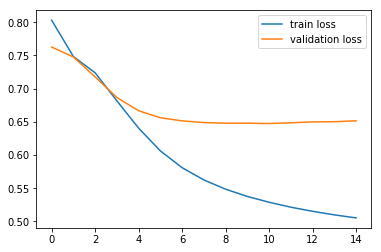

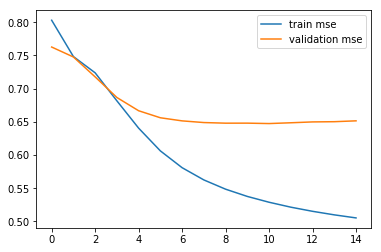

In [10]:
model1.save("movieLensRecommender_rncf1.h5")
plot(history1)

Inference on all data using model1 to create predicted ratings as the training input for the second model.

In [11]:
errors = []

for index, row in movieDF.iterrows():
    pred = model1.predict([[row.userId], [row.movieId]])
    pred = pred[0][0]
    mse = (row.rating - pred)**2
    errors.append(mse)

In [12]:
movieDF['error'] = errors
movieDF.head(5)

,userId,movieId,rating,error
445628,3031,2700,3.5,11.714023
300498,2062,457,4.0,10.846396
1810055,12208,2640,3.0,9.672417
862730,5768,2117,3.5,15.864624
3318896,22688,3825,2.5,12.129237


## Model 2: Reliability MNN

In [13]:
userInput = Input(shape=(1,))
movieInput = Input(shape=(1,))
userEmbedding = Embedding(userNum, K)(userInput)
movieEmbedding = Embedding(movieNum, K)(movieInput)
userEmbeddingFlat = Flatten()(userEmbedding) # bsize x k
movieEmbeddingFlat = Flatten()(movieEmbedding) # bsize x k
model2 = Concatenate()([userEmbeddingFlat, movieEmbeddingFlat])
model2 = Dense(512)(model2)
model2 = Dense(256)(model2)
model2 = Dense(256)(model2)
model2 = Activation('elu')(model2)
model2 = Dense(1)(model2)

model2 = Model(inputs=[userInput, movieInput], outputs=model2)
model2.compile(
    loss='mse',
    optimizer=Adam(lr=0.01),
    metrics=['mse']
)

Re-perform train-test-split using the updated movieLens dataset with the rating error.

In [14]:
trainSize = int(0.75*len(movieDF))
trainDF = movieDF.iloc[:trainSize]
testDF = movieDF.iloc[trainSize:]
trainDF.head(5)

,userId,movieId,rating,error
445628,3031,2700,3.5,11.714023
300498,2062,457,4.0,10.846396
1810055,12208,2640,3.0,9.672417
862730,5768,2117,3.5,15.864624
3318896,22688,3825,2.5,12.129237


In [15]:
history2 = model2.fit(
    x=[trainDF.userId.values, trainDF.movieId.values],
    y=trainDF.error.values,
    epochs=15,
    batch_size=128,
    validation_data=(
        [testDF.userId.values, testDF.movieId.values],
        testDF.error.values
    )
)

Train on 3750048 samples, validate on 1250017 samples
Epoch 1/15
3750048/3750048 [==============================] - 873s 233us/step - loss: 34.1746 - mse: 34.1746 - val_loss: 33.8165 - val_mse: 33.8165
Epoch 2/15
3750048/3750048 [==============================] - 874s 233us/step - loss: 35.3529 - mse: 35.3531 - val_loss: 30.6076 - val_mse: 30.6076
Epoch 3/15
3750048/3750048 [==============================] - 872s 233us/step - loss: 22.6777 - mse: 22.6776 - val_loss: 31.0549 - val_mse: 31.0549
Epoch 4/15
3750048/3750048 [==============================] - 871s 232us/step - loss: 22.6734 - mse: 22.6733 - val_loss: 30.6317 - val_mse: 30.6317
Epoch 5/15
3750048/3750048 [==============================] - 872s 233us/step - loss: 22.6713 - mse: 22.6713 - val_loss: 30.3925 - val_mse: 30.3924
Epoch 6/15
3750048/3750048 [==============================] - 872s 232us/step - loss: 22.6750 - mse: 22.6750 - val_loss: 30.4452 - val_mse: 30.4452
Epoch 7/15
3750048/3750048 [==============================

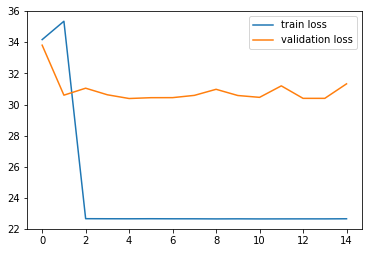

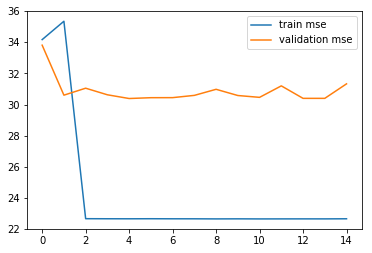

In [16]:
model2.save("movieLensRecommender_rncf2.h5")
plot(history2)

Again, inference on all data using model2 to create predicted errors as the training input for the third model.

In [17]:
pred_errors = []

for index, row in movieDF.iterrows():
    pred = model2.predict([[row.userId], [row.movieId]])
    pred = pred[0][0]
    pred_errors.append(pred)

In [18]:
movieDF['pred_error'] = pred_errors
movieDF.head(5)

,userId,movieId,rating,error,pred_error
445628,3031,2700,3.5,11.714023,12.043268
300498,2062,457,4.0,10.846396,12.043268
1810055,12208,2640,3.0,9.672417,12.043268
862730,5768,2117,3.5,15.864624,12.043268
3318896,22688,3825,2.5,12.129237,12.043268


## Model 3: Inference MNN

In [19]:
userInput = Input(shape=(1,))
movieInput = Input(shape=(1,))
predErrorInput = Input(shape=(1,)) # bsize x 1
userEmbedding = Embedding(userNum, K)(userInput)
movieEmbedding = Embedding(movieNum, K)(movieInput)
userEmbeddingFlat = Flatten()(userEmbedding) # bsize x k
movieEmbeddingFlat = Flatten()(movieEmbedding) # bsize x k
model3 = Concatenate()([userEmbeddingFlat, movieEmbeddingFlat, predErrorInput]) # bsize x (2k+1)
model3 = Dense(512)(model3)
model3 = Dense(256)(model3)
model3 = Dense(256)(model3)
model3 = Activation('elu')(model3)
model3 = Dense(1)(model3)

model3 = Model(inputs=[userInput, movieInput, predErrorInput], outputs=model3)
model3.compile(
    loss='mse',
    optimizer=Adam(lr=0.01),
    metrics=['mse']
)

Again, re-perform train-test-split using the updated movieLens dataset with the predicted error.

In [20]:
trainSize = int(0.75*len(movieDF))
trainDF = movieDF.iloc[:trainSize]
testDF = movieDF.iloc[trainSize:]
trainDF.head(5)

,userId,movieId,rating,error,pred_error
445628,3031,2700,3.5,11.714023,12.043268
300498,2062,457,4.0,10.846396,12.043268
1810055,12208,2640,3.0,9.672417,12.043268
862730,5768,2117,3.5,15.864624,12.043268
3318896,22688,3825,2.5,12.129237,12.043268


In [21]:
history3 = model3.fit(
    x=[trainDF.userId.values, trainDF.movieId.values, trainDF.pred_error.values],
    y=trainDF.rating.values,
    epochs=15,
    batch_size=128,
    validation_data=(
        [testDF.userId.values, testDF.movieId.values, testDF.pred_error.values],
        testDF.rating.values
    )
)

Train on 3750048 samples, validate on 1250017 samples
Epoch 1/15
3750048/3750048 [==============================] - 862s 230us/step - loss: 64.4913 - mse: 64.4912 - val_loss: 1.1639 - val_mse: 1.1639
Epoch 2/15
3750048/3750048 [==============================] - 870s 232us/step - loss: 1.1658 - mse: 1.1658 - val_loss: 1.2406 - val_mse: 1.2406
Epoch 3/15
3750048/3750048 [==============================] - 864s 230us/step - loss: 1.1664 - mse: 1.1664 - val_loss: 1.1122 - val_mse: 1.1122
Epoch 4/15
3750048/3750048 [==============================] - 865s 231us/step - loss: 1.1668 - mse: 1.1668 - val_loss: 1.5272 - val_mse: 1.5272
Epoch 5/15
3750048/3750048 [==============================] - 864s 230us/step - loss: 1.1659 - mse: 1.1659 - val_loss: 1.3073 - val_mse: 1.3073
Epoch 6/15
3750048/3750048 [==============================] - 863s 230us/step - loss: 1.1642 - mse: 1.1642 - val_loss: 1.1192 - val_mse: 1.1192
Epoch 7/15
3750048/3750048 [==============================] - 862s 230us/step - 

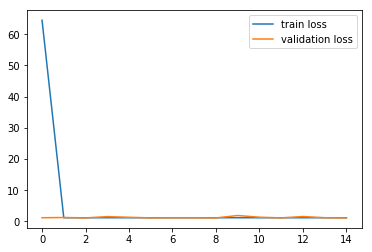

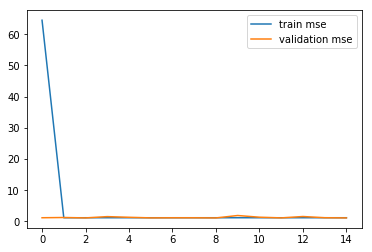

In [22]:
model3.save("movieLensRecommender_rncf3.h5")
plot(history3)

## Sample Inference and Metrics

In [26]:
def predictRating(num):
    pred_error = model2.predict([[movieDF.iloc[num].userId], [movieDF.iloc[num].movieId]])
    pred_error = pred_error[0][0]
    result = model3.predict([[movieDF.iloc[num].userId], [movieDF.iloc[num].movieId], [pred_error]])
    return [result[0][0], movieDF.iloc[num].rating]

def test(times):
    top = len(movieDF)-1
    for _ in range(times):
        num = random.randint(0, top)
        result = predictRating(num)
        print("(Predicted Rating, Real Rating): ({0}, {1})".format(result[0], result[1]))

test(10)

(Predicted Rating, Real Rating): (4.054775714874268, 5.0)
(Predicted Rating, Real Rating): (4.996739387512207, 5.0)
(Predicted Rating, Real Rating): (3.8663785457611084, 4.0)
(Predicted Rating, Real Rating): (3.9270434379577637, 4.0)
(Predicted Rating, Real Rating): (3.9943039417266846, 4.5)
(Predicted Rating, Real Rating): (2.8923263549804688, 3.5)
(Predicted Rating, Real Rating): (3.4835503101348877, 4.0)
(Predicted Rating, Real Rating): (3.1241343021392822, 3.0)
(Predicted Rating, Real Rating): (3.3643698692321777, 3.5)
(Predicted Rating, Real Rating): (3.432689666748047, 4.0)


In [24]:
from sklearn.metrics import mean_squared_error

predictions = np.empty((0))

for index, _ in enumerate(testDF.iterrows()):
    pred = predictRating(index)
    pred = pred[0]
    predictions = np.append(predictions, pred)

print('Validation MSE:', mean_squared_error(testDF.rating.values, predictions))

Validation MSE: 1.1125286187700671


# Conclusion

This notebook implements a recommender system using the traditional collaborative filtering matrix factorization technique with residual learning, and compared it with the implementation of a new residual learning technique using a deep learning architecture, proposed by Bobadilla, Alonso, and Hernando, using matrix factorization, residual learning and deep feedforward neural nets. It is observed that the newly-proposed deep learning architecture has greater error than the traditional approach, which may be attributed to the reduced dataset size, lack of bias terms and regularizations in the matrix factorization stage, etc. 